In [1]:
import d2l
import torch
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from torch import nn

In [2]:

finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = torch.nn.Linear(finetune_net.fc.in_features, 8)
torch.nn.init.xavier_uniform_(finetune_net.fc.weight);

In [3]:

normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])
mydata = torchvision.datasets.ImageFolder('input_data/', transform=data_transforms)
num_train = int(len(mydata)*0.75)
train_data, test_data = torch.utils.data.random_split(mydata, [num_train, len(mydata)-num_train])

In [6]:

train_loss = []
train_accs = []
test_accs = []
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(finetune_net.parameters(),lr=1e-4,momentum=0.9)
num_epochs = 15
train_iter = DataLoader(train_data, 64, shuffle=True)
test_iter = DataLoader(test_data, 64)
for epoch in range(num_epochs):
    running_loss=0.00
    running_correct=0.0
    print("Epoch  {}/{}".format(epoch, num_epochs))
    
    for i,data in enumerate(train_iter,0):
        inputs,labels=data
        optimizer.zero_grad()
        outputs=finetune_net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        _, pred = torch.max(outputs.data, 1)
        running_correct += torch.sum(pred == labels.data)
        
    l = running_loss / len(train_data)
    train_acc = running_correct / len(train_data)
    train_accs.append(train_acc)
    train_loss.append(l)

    with torch.no_grad():
        running_correct=0.00
        for i, data in enumerate(test_iter, 0):
            inputs, labels = data
            outputs = finetune_net(inputs)
            _, pred = torch.max(outputs.data, 1)
            running_correct += torch.sum(pred == labels.data)
        test_acc = running_correct / len(test_data)
        test_accs.append(test_acc)     
    print("Loss is :{:.4f}, Train Accuracy is:{:.4f}, Test Accuracy is:{:.4f}".format(l, train_acc, test_acc))

Epoch  0/15
Loss is :0.0207, Train Accuracy is:0.5853, Test Accuracy is:0.8074
Epoch  1/15
Loss is :0.0086, Train Accuracy is:0.8517, Test Accuracy is:0.8915
Epoch  2/15
Loss is :0.0061, Train Accuracy is:0.8962, Test Accuracy is:0.9118
Epoch  3/15
Loss is :0.0049, Train Accuracy is:0.9155, Test Accuracy is:0.9072
Epoch  4/15
Loss is :0.0041, Train Accuracy is:0.9302, Test Accuracy is:0.9304
Epoch  5/15
Loss is :0.0037, Train Accuracy is:0.9339, Test Accuracy is:0.9437
Epoch  6/15
Loss is :0.0033, Train Accuracy is:0.9372, Test Accuracy is:0.9310
Epoch  7/15
Loss is :0.0029, Train Accuracy is:0.9484, Test Accuracy is:0.9472
Epoch  8/15
Loss is :0.0027, Train Accuracy is:0.9526, Test Accuracy is:0.9571
Epoch  9/15
Loss is :0.0028, Train Accuracy is:0.9468, Test Accuracy is:0.9472
Epoch  10/15
Loss is :0.0024, Train Accuracy is:0.9519, Test Accuracy is:0.9484
Epoch  11/15
Loss is :0.0025, Train Accuracy is:0.9532, Test Accuracy is:0.9559
Epoch  12/15
Loss is :0.0023, Train Accuracy is:0.

In [7]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

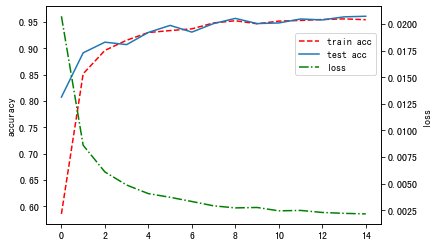

In [32]:

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
x = range(num_epochs)
ax1.plot(x, train_accs, 'r--', label='train acc')
ax1.plot(x, test_accs, label='test acc')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax2.plot(x, train_loss, 'g-.', label='loss')
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9), bbox_transform=ax1.transAxes)

In [62]:

def tensor2im(input_image, imtype=np.uint8):
    mean = [0.485,0.456,0.406] 
    std = [0.229,0.224,0.225]  
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor): 
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor.cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        for i in range(len(mean)): 
            image_numpy[i] = image_numpy[i] * std[i] + mean[i]
        image_numpy = image_numpy * 255 
        image_numpy = np.transpose(image_numpy, (1, 2, 0))  
    else:  
        image_numpy = input_image
    return image_numpy.astype(imtype)

# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

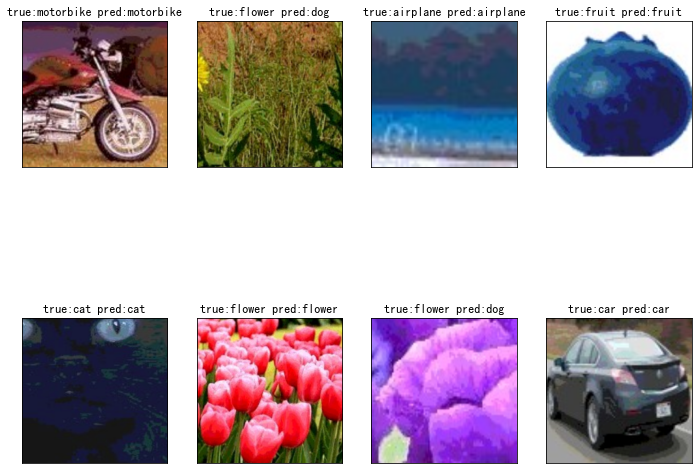

In [85]:

classes = [i.split('_')[0] for i in mydata.classes]
with torch.no_grad():
    inputs, labels = iter(test_iter).next()
    outputs = finetune_net(inputs[:8])
    _, pred = torch.max(outputs.data, 1)
    plt.figure(figsize=(12,10))
    num = 0
    while num < 8:
        plt.subplot(2, 4, num+1)
        img = tensor2im(inputs[num])
        disp_image(np.array(img))
        plt.title(f"true:{classes[labels[num]]} pred:{classes[pred[num]]}")
        num += 1

In [88]:

torch.save(finetune_net, 'model.pt')